In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Autheticate and then initialize the session using your credentials
#ee.Authenticate()
ee.Initialize()

In [356]:
def return_time_series_collection(start_time='2000-01-01',end_time='2018-01-01',
                       data_source='LANDSAT/LC8_L1T_TOA',
                       cloud_cover=5,
                       input_bands=['B4','B5','B6'],
                       roi = [5.727906, 51.993435,
                                 5.588144, 51.944356]):
    '''
    Time: yyyy-mm-dd
    roi: Region-of-interest
    
    '''
    
    ## Define your image collection 
    collection = ee.ImageCollection(data_source)
    
    ## Define time range and filter the data
    collection_time = collection.filterDate(start_time, end_time) #YYYY-MM-DD
    
    x0,y0,x1,y1 = roi
    
    ROI = ee.Geometry.Rectangle([x0,y0,
                                 x1,y1])
    
    
    
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_PATH', 198))
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_ROW', 24))
    
    # Filter by a specific region
    filterRegion = collection_time.filterBounds(ROI)
    
    ## Select imagery with less then 5% of image covered by clouds
    clouds = filterRegion.filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
    
    ## Select bands
    bands = clouds.select(input_bands)
    
    collectionList = bands.toList(bands.size()) # Converts the image collection to a list accessible via index
    collectionSize = collectionList.size().getInfo()
    
    # Get the information about the dates of this collection
    collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['DATE_ACQUIRED'] for indx in range(collectionSize)]
    
    
    return collectionSize,collectionList,collectionDates


def normalize(data):
    '''
    Normalize the data from 0->1
    '''
    
    norm = (data-data.min())/(data.max()-data.min())
    
    return norm

def convert_image_to_numpy(image,
                           roi=[5.727906, 51.993435,
                                5.588144, 51.944356],
                           input_bands=['B4','B5','B6'],
                          normalized=True):
    '''
    Converts a single image in the collection List to a numpy array
    '''
    
    
    #image = ee.Image(collectionList.get(indx))
    ROI = ee.Geometry.Rectangle(roi)
    
    band_arrs = image.sampleRectangle(region=ROI)
    #band_arrs = image.stratifiedSample(region=ROI)
    
    img_arrays = [ np.array(band_arrs.get(band).getInfo()) for band in input_bands]
    
    # Rescale the arrays
    if(normalized==True):
        img_arrays = [normalize(img_array) for img_array in img_arrays]
    
    img_arrays = [np.expand_dims(img_array, 2) for img_array in img_arrays]
    rgb_img = np.concatenate(img_arrays, 2)
    
    
    return rgb_img


def train_Kmeans_classifier(img,K,roi):
    '''
    This simple function trains a K-means classifier on an image
    '''
    
    input = ee.Image(img)
    
    ROI = ee.Geometry.Rectangle(roi)
    
    # Make the training dataset.
    training = input.sample(**{
        'region': ROI,
        'scale': 30,
        'numPixels': 5000
    })

    
    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(K).train(training)
    
    return clusterer

def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results
    


In [400]:
#vec = [5.727906, 51.993435, 5.588144, 51.944356]


bands = ['B3','B2','B1'] #LSAT7
#bands = ['B4','B3','B2'] # LSAT8#
#
vec = [133.35830,-31.372,133.455539,-31.326256]
#vec = [5.727906, 51.993435,5.588144, 51.944356]
#vec = [-10.794301,-62.328798,-10.820638,-62.368717]

# collectionSize,collectionList,collectionDates = return_time_series_collection(start_time='2014-01-01',
#                     end_time='2019-01-01',
#                     data_source='LANDSAT/LC8_L1T_TOA',
#                     cloud_cover=20,
#                     input_bands=bands,roi=vec )

collectionSize,collectionList,collectionDates = return_time_series_collection(start_time='1990-01-01',
                    end_time='2010-01-01',
                    data_source='LANDSAT/LE07/C01/T1',
                    cloud_cover=5,
                    input_bands=bands,roi=vec )

print('='*100)
print('Dates:' )
print(collectionDates)
print('Length: ')
print(collectionSize)
print('='*100)

ROI = ee.Geometry.Rectangle([5.727906, 51.993435,
                                   5.588144, 51.944356])

# Define the region of interest
#ROI = ee.Geometry.Rectangle(vec)
    
# Choose a specific image from the collection List
indx = 2

image = ee.Image(collectionList.get(indx))

parameters = {'min': 0,
               'max':0.5,
               'bands': bands,
               'region': ROI }

# Plot the satellite image
Image(url = image.getThumbUrl(parameters))

Dates:
['1999-08-24', '1999-10-27', '1999-11-28', '2000-10-29', '2000-11-30', '2001-01-01', '2001-01-17', '2001-05-25', '2001-08-13', '2001-09-14', '2001-09-30', '2002-01-04', '2002-03-09', '2002-06-29', '2002-08-16', '2002-09-01', '2003-02-08', '2003-03-12', '2003-03-28', '2003-07-18', '2003-12-09', '2003-12-25', '2004-02-11', '2004-02-27', '2004-03-14', '2004-07-20', '2004-08-21', '2004-10-08', '2004-11-25', '2005-01-12', '2005-02-13', '2005-10-27', '2005-11-12', '2005-11-28', '2005-12-14', '2006-02-16', '2006-03-20', '2006-05-23', '2006-07-10', '2006-08-11', '2007-02-03', '2007-02-19', '2007-03-07', '2007-04-08', '2007-06-27', '2007-08-30', '2007-09-15', '2007-10-01', '2007-10-17', '2007-11-18', '2008-03-09', '2008-05-12', '2008-05-28', '2008-09-01', '2008-09-17', '2009-01-23', '2009-02-24', '2009-03-12', '2009-03-28', '2009-05-31', '2009-07-18', '2009-08-03', '2009-09-20', '2009-11-07', '2009-11-23']
Length: 
65


In [401]:
image = ee.Image(collectionList.get(20))
rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)

plt.figure(figsize=(10,10))
plt.imshow(rgb_img_normed+0.2)

image = ee.Image(collectionList.get(collectionSize-3))
rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)

plt.figure(figsize=(10,10))
plt.imshow(rgb_img_normed+0.2)

EEException: Image.sampleRectangle: Fully masked pixels / pixels outside of the image footprint when sampling band 'B1' with no default value set. Note that calling sampleRectangle() on an image after ee.Image.clip() may result in a sampling bounding box outside the geometry passed to clip().

In [408]:
image = ee.Image(collectionList.get(2))

# K-means clustering
kmeans = train_Kmeans_classifier(img=image,K=5,roi=vec)

# Cluster the input using the trained clusterer.
result = image.cluster(kmeans)

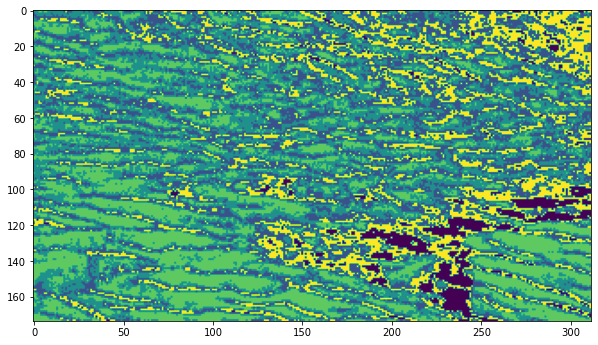

In [409]:
ROI = ee.Geometry.Rectangle(vec)
band_arrs = result.sampleRectangle(region=ROI)
data = np.array(band_arrs.get('cluster').getInfo())

plt.figure(figsize=(10,10))
plt.imshow(data)
plt.show()

In [421]:
time_series =  []
ts_dates = []
labels = range(0,5)

for i in range(0,collectionSize):
    image = ee.Image(collectionList.get(i))
    #data= convert_image_to_numpy(image,roi=vec,input_bands=['B4','B3','B2'],normalized=True)
    
    try:
        ts = count_pixels_per_class(image,K=5,classifier=kmeans,vec=vec)
        time_series.append(ts)
        ts_dates.append(collectionDates[i])
    except:
        print('Exception!: ',i)
        pass
    
    #time_series.append(ts)

Exception!:  19
Exception!:  20
Exception!:  21
Exception!:  22
Exception!:  23
Exception!:  24
Exception!:  25
Exception!:  26
Exception!:  27
Exception!:  28
Exception!:  29
Exception!:  30
Exception!:  31
Exception!:  32
Exception!:  33
Exception!:  34
Exception!:  35
Exception!:  36
Exception!:  37
Exception!:  38
Exception!:  39
Exception!:  40
Exception!:  41
Exception!:  42
Exception!:  43
Exception!:  44
Exception!:  45
Exception!:  46
Exception!:  47
Exception!:  48
Exception!:  49
Exception!:  50
Exception!:  51
Exception!:  52
Exception!:  53
Exception!:  54
Exception!:  55
Exception!:  56
Exception!:  57
Exception!:  58
Exception!:  59
Exception!:  60
Exception!:  61
Exception!:  62
Exception!:  63
Exception!:  64


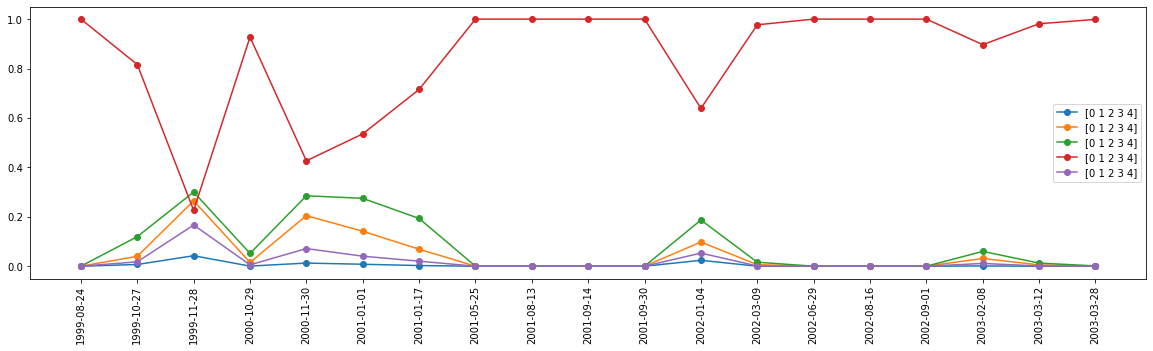

19


In [425]:
plt.figure(figsize=(20,5))
plt.plot(ts_dates, time_series,'-o',label=np.array(labels))
plt.xticks(rotation='90')
plt.legend()
plt.show()

print(len(time_series))

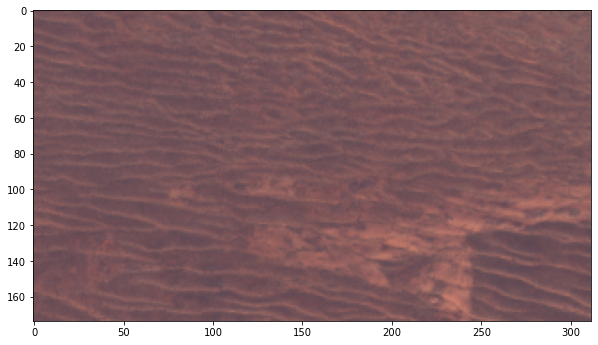

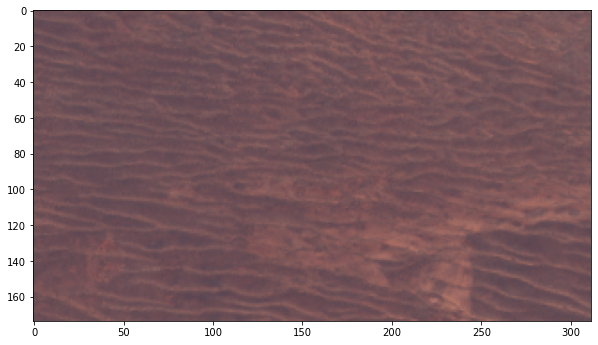

In [417]:
image = ee.Image(collectionList.get(1))
rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)

plt.figure(figsize=(10,10))
plt.imshow(rgb_img_normed)

image = ee.Image(collectionList.get(3))
rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)

plt.figure(figsize=(10,10))
plt.imshow(rgb_img_normed)